In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

from time import time

import multinet

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import cropset
import dataset

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
net = multinet.pretrained("./model_multinet.pt")
backbone = net.features
# backbone.out_channels = net.classifier[1].in_features
backbone.out_channels = 20
num_classes = net.classifier[-1].out_features

anchor_generator = AnchorGenerator(
    sizes=((10,30,40,),), aspect_ratios=((1.,.5,),))
    
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'], output_size=15, sampling_ratio=1)

"""
image_mean (Tuple[float, float, float]): mean values used for input normalization.
  They are generally the mean values of the dataset on which the backbone has been trained
  on
image_std (Tuple[float, float, float]): std values used for input normalization.
  They are generally the std values of the dataset on which the backbone has been trained on
"""

# therefore should probably train features with z-score standardized data and provide mena and std into FasterRCNN
#  https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py#L61-L65

mean = (.4016, .3075, .2541)
std = (.3068, .2605, .2465)

model = FasterRCNN(
  backbone, num_classes=num_classes, image_mean=mean, image_std=std, min_size=800, max_size=800,
  rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

model.to(device)

# pretrained convnet features but classifier is not taken from pretrained model

net, model

loaded module has 5 classes


(MultiNet(
   (features): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=3920, out_features=2600, bias=True)
     (2): ReLU(inplace=True)
     (3): Linear(in_features=2600, out_features=1000, bias=True)
     (4): ReLU(inplace=True)
     (5): Linear(in_features=1000, out_features=5, bias=True)
   )
 ),
 FasterRCNN(
   (transform): GeneralizedRCNNTransform(
       Normalize(mean=(0.4016, 0.3075, 0.2541), std=(0.3068, 0.2605, 0.2465))
       Resize(min_size=(800,), max_size=800, mode='bilinear')
   )
   (backbone): Sequential(
     (0): Conv2d(3, 12, kernel_size=(2, 2), stride=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(12, 20, kernel_size=(2, 2), stride=

In [5]:
torch.__version__, torchvision.__version__

('1.10.0+cu113', '0.11.1+cu113')

In [6]:
dl = cropset.load(cropset.CropSet())
len(dl.dataset)

120

In [7]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=.005, momentum=0.9, weight_decay=0.0005)

STEP = 2

mlosses, maccs = [], []
for epoch in range(22):
  r_loss, r_acc = 0., 0.
  s = time()
  for i, (img, l) in enumerate(dl):
    img, l = list(i.to(device) for i in img), [{k: v.to(device) for k, v in t.items()} for t in l]
    model.train()
    loss_dict = model(img, l)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    r_loss += losses
    r_acc += 0  # dunno
    
    log = False
    if (i+1) % STEP == 0:
      divisor = STEP
      log = True
    elif i+1 == len(dl):
      divisor = (i+1) % STEP
      log = True
    if log:
      mlosses.append(r_loss/divisor)
      maccs.append(r_acc/divisor)
      print(f"epoch:{epoch+1} loss:{mlosses[-1]:.4f} acc:{maccs[-1]:.2f} took:{time()-s:.2f}")
      s = time()
      r_loss, r_acc = 0., 0.


/home/spadge/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch:1 loss:2.4915 acc:0.00 took:0.63
epoch:1 loss:2.5411 acc:0.00 took:0.47
epoch:1 loss:2.5245 acc:0.00 took:0.44
epoch:1 loss:2.4592 acc:0.00 took:0.44
epoch:1 loss:2.4114 acc:0.00 took:0.45
epoch:1 loss:2.3902 acc:0.00 took:0.47
epoch:1 loss:2.1961 acc:0.00 took:0.44
epoch:1 loss:2.0837 acc:0.00 took:0.44
epoch:1 loss:1.9908 acc:0.00 took:0.46
epoch:1 loss:1.7870 acc:0.00 took:0.45
epoch:1 loss:1.6367 acc:0.00 took:0.45
epoch:1 loss:1.4781 acc:0.00 took:0.45
epoch:1 loss:1.3266 acc:0.00 took:0.44
epoch:1 loss:1.3058 acc:0.00 took:0.45
epoch:1 loss:1.3786 acc:0.00 took:0.44
epoch:2 loss:1.2998 acc:0.00 took:0.42
epoch:2 loss:1.4714 acc:0.00 took:0.45
epoch:2 loss:1.3422 acc:0.00 took:0.44
epoch:2 loss:1.3873 acc:0.00 took:0.45
epoch:2 loss:1.0873 acc:0.00 took:0.43
epoch:2 loss:1.1779 acc:0.00 took:0.45
epoch:2 loss:1.1497 acc:0.00 took:0.44
epoch:2 loss:1.1256 acc:0.00 took:0.43
epoch:2 loss:1.1041 acc:0.00 took:0.44
epoch:2 loss:1.0749 acc:0.00 took:0.43
epoch:2 loss:1.0551 acc:0

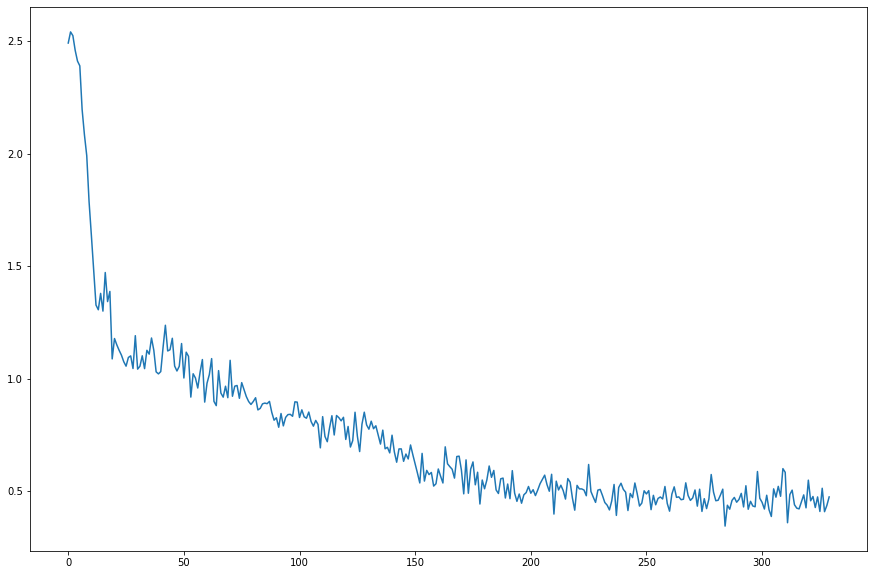

In [8]:
plt.figure(figsize=(15,10))
ax = plt.plot([i.detach().item() for i in mlosses])
plt.show()


torch.Size([3, 640, 800])
tensor([0.9857, 0.9805, 0.9725, 0.9723, 0.9723, 0.9654, 0.9606, 0.9606, 0.9605,
        0.3559, 0.1077, 0.0884, 0.0665, 0.0664, 0.0544], device='cuda:0')
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False], device='cuda:0')


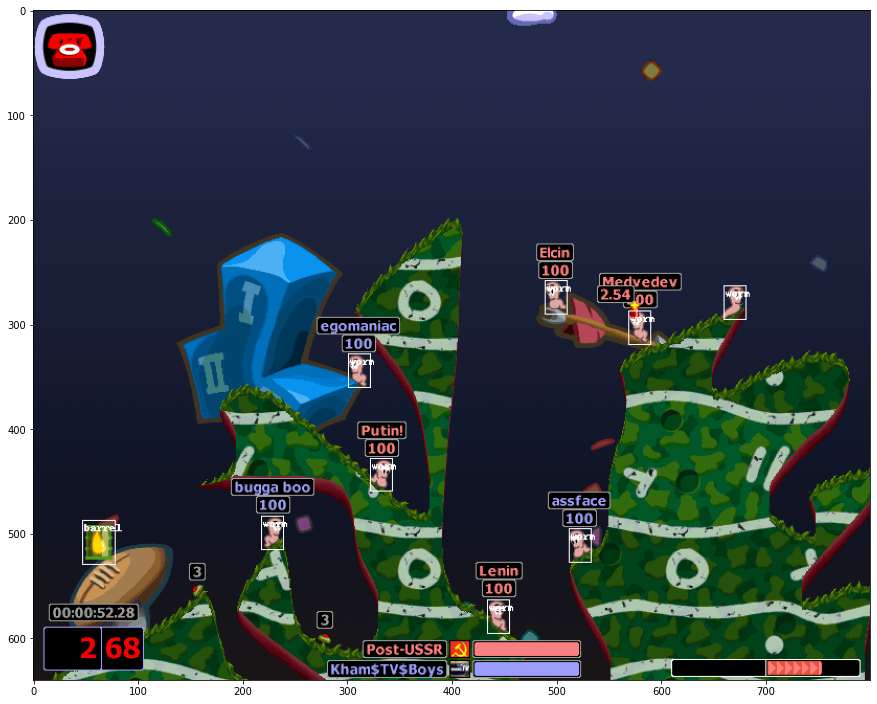

['bg', 'worm', 'mine', 'barrel', 'dynamite']

In [11]:
with torch.no_grad():
#   mean, std = (.4016, .3075, .2541), (.3068, .2605, .2465)  # from feature trainset
  mean, std = (0.2945, 0.2550, 0.2586), (0.2492, 0.2100, 0.2303)  # from capture set
#   transform = Compose([ToTensor(), Normalize(mean=mean, std=std)])
  transform = Compose([ToTensor()])
  img = transform(Image.open("./labelling/source/2378_0_22947.png").convert('RGB'))
  print(img.shape)
  model.eval()
  y = model(img.unsqueeze(0).to(device))[0]
  print(y['scores'])

topk  = y['scores'] > .8
print(topk)
plt.figure(figsize=(15,15))
bb = draw_bounding_boxes(
  (img*255).to(torch.uint8), boxes=y['boxes'][topk], labels=[dataset.CLASSES[i] for i in y['labels'][topk]])
# bb = draw_bounding_boxes(
#   (img*255).to(torch.uint8), boxes=y['boxes'], labels=[dataset.CLASSES[i] for i in y['labels']])
plt.imshow(bb.permute(1,2,0))
plt.show()
dataset.CLASSES

In [ ]:
models.detection.fasterrcnn_resnet50_fpn()

In [ ]:
models.mobilenet_v2()